In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, confusion_matrix, accuracy_score, log_loss


import sklearn
sklearn.set_config(display="Text")
pd.set_option('display.max_columns', None)

In [2]:
file_path = "../train.csv"
data = pd.read_csv(file_path)

train_full, test = train_test_split(data, random_state=42, stratify=data["Class"])
train, valid = train_test_split(train_full, random_state=42, stratify=train_full["Class"])

X_train, y_train = train.drop(["Class"], axis=1), train["Class"].copy()
X_test, y_test = test.drop(["Class"], axis=1), test["Class"].copy()
X_valid, y_valid = valid.drop(["Class"], axis=1), valid["Class"].copy()

# Preprocessing

In [3]:
class input_outlier(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.feature_names_in = X.columns
        self.upper_limit = X.quantile(0.99)
        self.lower_limit = X.quantile(0.01)
        return self
    def transform(self, X, y=None):
        fixed_X = np.where(X>self.upper_limit, self.upper_limit, np.where(X<self.lower_limit, self.lower_limit, X))
        return fixed_X
    def get_feature_names_out(self, names=None):
        return self.feature_names_in

In [4]:
log_transformer = FunctionTransformer(np.log, feature_names_out="one-to-one")

num_pipeline = make_pipeline(
    input_outlier(),
    SimpleImputer(strategy="median"),
    log_transformer,
    StandardScaler()
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder()
)

cleaning = ColumnTransformer([
    ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
    ("cat", cat_pipeline, ["EJ"]),
])

preprocessing = Pipeline([
    ("clean", cleaning),
    ("poly_feat", PolynomialFeatures(degree=3))
])

In [5]:
X_train_clean = preprocessing.fit_transform(X_train)
X_valid_clean = preprocessing.transform(X_valid)
X_test_clean = preprocessing.transform(X_test)

In [6]:
import tensorflow as tf

In [6]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(2, activation="softmax")
])

model_1.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [8]:
history_1 = model_1.fit(X_train_clean, y_train, epochs=30, validation_data=[X_valid_clean, y_valid])

Epoch 1/30
11/11 [==============================] - 6s 198ms/step - loss: 0.8274 - accuracy: 0.7803 - val_loss: 0.3003 - val_accuracy: 0.8793
Epoch 2/30
11/11 [==============================] - 1s 92ms/step - loss: 0.0932 - accuracy: 0.9942 - val_loss: 0.3270 - val_accuracy: 0.9138
Epoch 3/30
11/11 [==============================] - 1s 87ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 0.3189 - val_accuracy: 0.9138
Epoch 4/30
11/11 [==============================] - 1s 79ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.3166 - val_accuracy: 0.9138
Epoch 5/30
11/11 [==============================] - 1s 66ms/step - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.3157 - val_accuracy: 0.9138
Epoch 6/30
11/11 [==============================] - 1s 72ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.3156 - val_accuracy: 0.9138
Epoch 7/30
11/11 [==============================] - 1s 71ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.3161 - val_accuracy: 0.9224
Epoch 8/30
1

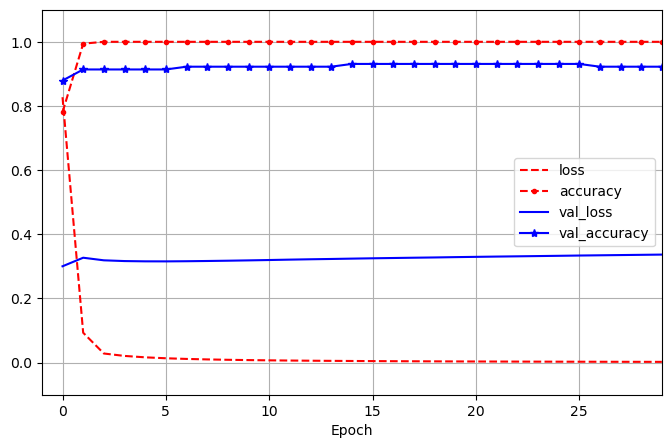

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history_1.history).plot(figsize=(8, 5), xlim=[-1, 29], ylim=[-0.1, 1.1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [13]:
model_1.evaluate(X_test_clean, y_test)

5/5 [==============================] - 0s 71ms/step - loss: 0.5069 - accuracy: 0.8645


[0.5069248080253601, 0.8645161390304565]

In [25]:
y_valid_pred = model_1.predict(X_valid_clean)
y_test_pred = model_1.predict(X_test_clean)

print(f"Log Loss Validation set: {log_loss(y_valid, y_valid_pred[:,1])}")
print(f"Log Loss Test set: {log_loss(y_test, y_test_pred[:,1])}")

5/5 [==============================] - 0s 65ms/step
Log Loss Validation set: 0.33677415047902454
Log Loss Test set: 0.4871192869820216


In [18]:
import keras_tuner as kt

In [19]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=5, default=2)
    n_neurons = hp.Int("n_neurons", min_value=10, max_value=50)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    
    if optimizer=="sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
    model = tf.keras.Sequential()
    
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(2, activation="softmax"))
    
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [20]:
random_search_tuner = kt.RandomSearch(build_model, objective="val_accuracy", max_trials=5, overwrite=True, directory="my_ICR_project", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train_clean, y_train, epochs=10, validation_data=(X_valid_clean, y_valid))

Trial 5 Complete [00h 00m 08s]
val_accuracy: 0.8275862336158752

Best val_accuracy So Far: 0.9224137663841248
Total elapsed time: 00h 00m 44s
INFO:tensorflow:Oracle triggered exit


In [21]:
best_model = random_search_tuner.get_best_models(num_models=3)[0]

In [24]:
best_model.evaluate(X_test_clean, y_test)

5/5 [==============================] - 2s 30ms/step - loss: 0.8296 - accuracy: 0.8774


[0.8295931220054626, 0.8774193525314331]

In [27]:
best_params =random_search_tuner.get_best_hyperparameters(num_trials=3)
best_params.values

AttributeError: 'list' object has no attribute 'values'